In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.optimizers import Adam

In [2]:
# Get the original dataset from https://www.kaggle.com/mlg-ulb/creditcardfraud/
creditdata=pd.read_csv(r'C:\Users\fhasan1\creditcard.csv', header=None)  
print(creditdata.shape)
creditdata=np.array(creditdata)
creditdata=np.delete(creditdata,0,0) # removing the header
print(creditdata.shape)

C:\Users\fhasan1\Anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(284808, 31)
(284807, 31)


In [3]:
# input feature and target 
inputData=creditdata[0:,0:30]
target=creditdata[0:,30:]

print(inputData.shape)
print(target.shape)

(284807, 30)
(284807, 1)


In [4]:
inputData = np.array(inputData, dtype="float32")
target = np.array(target, dtype="float32")

#counting the number of true and false transaction
zero_occurrences = np.count_nonzero(target == 0)
one_occurrences = np.count_nonzero(target == 1)

print(zero_occurrences)
print(one_occurrences)

284315
492


In [5]:
# Annalysing the imbalanced in dataset
print("Number of false transation (positive sample) in training data: {} ({:.2f}% of total)".format(one_occurrences, 100 * float(one_occurrences) / len(target)))

weight_0 = 1.0 / zero_occurrences
weight_1 = 1.0 / one_occurrences

Number of false transation (positive sample) in training data: 492 (0.17% of total)


In [6]:
# training and test 
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(inputData, target, test_size = 0.2,random_state = 5 ,shuffle=True)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(227845, 30)
(227845, 1)
(56962, 30)
(56962, 1)


In [7]:
# Normalizing the features
mean = np.mean(x_train, axis=0)
x_train -= mean
x_test -= mean
std = np.std(x_train, axis=0)
x_train /= std
x_test /= std

In [8]:
model_credit = Sequential()
model_credit.add(Dense(256, input_dim=np.size(inputData,1), activation='relu'))
model_credit.add(Dense(256, activation='relu'))
model_credit.add(Dense(256, activation='relu'))
model_credit.add(Dense(256, activation='relu'))
model_credit.add(Dense(1, activation='sigmoid'))

model_credit.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               7936      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 205,569
Trainable params: 205,569
Non-trainable params: 0
_________________________________________________________________


In [9]:
import tensorflow.keras.backend as K

def f2(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    f2 = 5*p*r / (4*p+r+K.epsilon())
    return K.mean(f2)

def f2_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    f2 = 5*p*r / (4*p+r+K.epsilon())
    return 1 - K.mean(f2)

metrics = [
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
]

In [10]:
model_credit.compile(optimizer=Adam(1e-5), loss=f2_loss, metrics=['accuracy',f2])
#model_credit.compile(optimizer=Adam(1e-2), loss="binary_crossentropy", metrics=metrics)

#callbacks = [keras.callbacks.ModelCheckpoint("fraud_model_at_epoch_{epoch}.h5")]
class_weight = {0: weight_0, 1: weight_1}

#class_weight: Optional dictionary mapping class indices (integers) to a weight (float) value, 
#used for weighting the loss function (during training only). 
#This can be useful to tell the model to 
#"pay more attention" to samples from an under-represented class.

#f2 score and class weight can not be used simultaneously
history=model_credit.fit(x_train, y_train,batch_size=2048,epochs=30, verbose=2,validation_split=0.2,
    #callbacks=callbacks,
    #class_weight=class_weight,
                        )

Train on 182276 samples, validate on 45569 samples
Epoch 1/30
182276/182276 - 2s - loss: 0.9898 - accuracy: 0.9708 - f2: 0.1377 - val_loss: 0.9863 - val_accuracy: 0.9595 - val_f2: 0.1659
Epoch 2/30
182276/182276 - 1s - loss: 0.9865 - accuracy: 0.9786 - f2: 0.2570 - val_loss: 0.9833 - val_accuracy: 0.9943 - val_f2: 0.5442
Epoch 3/30
182276/182276 - 1s - loss: 0.9836 - accuracy: 0.9979 - f2: 0.6695 - val_loss: 0.9786 - val_accuracy: 0.9993 - val_f2: 0.7984
Epoch 4/30
182276/182276 - 1s - loss: 0.9785 - accuracy: 0.9993 - f2: 0.7024 - val_loss: 0.9706 - val_accuracy: 0.9994 - val_f2: 0.7793
Epoch 5/30
182276/182276 - 1s - loss: 0.9649 - accuracy: 0.9993 - f2: 0.7401 - val_loss: 0.9394 - val_accuracy: 0.9993 - val_f2: 0.7529
Epoch 6/30
182276/182276 - 1s - loss: 0.8842 - accuracy: 0.9993 - f2: 0.6407 - val_loss: 0.7151 - val_accuracy: 0.9993 - val_f2: 0.7215
Epoch 7/30
182276/182276 - 1s - loss: 0.5179 - accuracy: 0.9993 - f2: 0.7074 - val_loss: 0.3558 - val_accuracy: 0.9993 - val_f2: 0.72

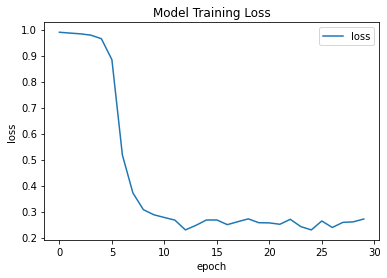

In [11]:
#print(history.history.keys())
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Model Training Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper right')          
plt.show()

In [13]:
# prediction 
y_pred=model_credit.predict(x_test)
print(y_pred.shape)

#any transaction more than 40% probability of fraud will be counted as fraudulant transaction
y_pred[y_pred >= 0.4] = 1
y_pred[y_pred < 0.4] = 0

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

(56962, 1)
[[56845    13]
 [   22    82]]
